# 📘 머신러닝 기반 이상 탐지

주제: 지도학습(Random Forest)과 비지도학습(Isolation Forest)을 비교하고, 디지털 트윈 대시보드 시각화하기

## 실습 개요
1. 실습 환경 설정 및 데이터 로드
이번 실습에서는 실제 제조 데이터인 UCI AI4I 2020 예측 정비 데이터셋을 사용합니다. 우리의 목표는 두 가지입니다.

- 지도학습(Supervised): 정답(고장 여부)을 알려주고 학습시켰을 때의 성능 확인

- 비지도학습(Unsupervised): 정답 없이 데이터의 패턴만 보고 이상 징후를 스스로 찾아내는 Digital Twin의 핵심 기술 구현

- 먼저 필요한 라이브러리를 임포트하고 데이터를 불러옵니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 한글 폰트 설정 (앞선 실습에서 설정했으므로 생략 가능하나 확인차 포함)
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

# UCI AI4I 2020 데이터셋 로드
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
df = pd.read_csv(url)

# 데이터 확인
print(f"전체 데이터 크기: {df.shape}")
df.head()

전체 데이터 크기: (10000, 14)


UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

##  데이터 준비
2. 학습용 데이터 준비 (Feature Selection)
제조 설비의 물리적 상태를 가장 잘 나타내는 핵심 센서 데이터 5가지를 선택합니다.

- X (특성): 공기 온도, 공정 온도, 회전 속도, 토크, 공구 마모 시간

- y (정답): 기계 고장 여부 (0: 정상, 1: 고장)

- 데이터를 **학습용(Train)**과 **테스트용(Test)**으로 8:2 비율로 나눕니다.

In [2]:
# 1. 학습에 사용할 특성(Feature) 선택
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

X = df[features]
y = df['Machine failure']

# 2. 학습/테스트 데이터 분리 (random_state=42로 고정하여 결과 재현성 확보)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터(Train): {X_train.shape}")
print(f"테스트 데이터(Test): {X_test.shape}")

학습 데이터(Train): (8000, 5)
테스트 데이터(Test): (2000, 5)


## 비교 실험 - 지도학습
3. [비교] 지도학습: Random Forest
먼저 전통적인 지도학습(Supervised Learning) 방식을 적용해 봅니다.
- 이 방식은 "이 데이터는 고장이야"라고 정답(y_train)을 알려주고 학습시킵니다.
- 성능은 매우 좋지만, 현실에서는 고장 데이터(라벨)를 구하기 어렵다는 단점이 있습니다.

In [3]:
from sklearn.ensemble import RandomForestClassifier

# 모델 생성 및 학습 (정답 y_train을 제공함)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측
y_pred_rf = rf_model.predict(X_test)

# 결과 리포트
print("=== 지도학습(Random Forest) 성능 평가 ===")
print(classification_report(y_test, y_pred_rf))

=== 지도학습(Random Forest) 성능 평가 ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.82      0.59      0.69        61

    accuracy                           0.98      2000
   macro avg       0.90      0.79      0.84      2000
weighted avg       0.98      0.98      0.98      2000



## 비교실험 - 비지도학습
4. [핵심] 비지도학습: Isolation Forest
이제 디지털 트윈의 진짜 기술인 비지도학습을 적용합니다. Isolation Forest(고립 숲) 알고리즘을 사용하며, 이번에는 정답(y_train)을 주지 않고 학습시킵니다.

- 원리: 정상 데이터는 빽빽하게 모여 있고, 이상 데이터(Anomaly)는 멀리 떨어져 있어 쉽게 '고립'된다는 점을 이용합니다.

- Contamination: 전체 데이터 중 불량품이 약 3% 정도 있을 것이라고 가정(0.03)합니다.

In [4]:
from sklearn.ensemble import IsolationForest

# 모델 생성 (contamination=0.03 : 전체의 3%를 이상치로 간주하겠다는 설정)
iso_model = IsolationForest(contamination=0.03, random_state=42)

# 학습 (주의: y_train 없이 X_train만으로 학습!)
iso_model.fit(X_train)

# 예측 (-1: 이상, 1: 정상) -> 결과를 우리가 이해하기 쉽게 0, 1로 변환 필요
y_pred_iso_raw = iso_model.predict(X_test)

# 변환: -1(이상) -> 1(고장), 1(정상) -> 0(정상)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso_raw]

# 결과 확인: 실제 고장(y_test)과 AI가 찾은 이상치(y_pred_iso) 비교
print("=== 비지도학습(Isolation Forest) 탐지 결과 ===")
print(confusion_matrix(y_test, y_pred_iso))

=== 비지도학습(Isolation Forest) 탐지 결과 ===
[[1897   42]
 [  52    9]]


## 시각화 (대시보드)
5. 디지털 트윈 상태 모니터링 시각화
마지막으로 AI가 분석한 결과를 시각적인 대시보드 형태로 구현합니다. 제조 현장에서 가장 중요한 상관관계인 [회전 속도(RPM) vs 토크(Torque)] 그래프를 그려보겠습니다.

- 파란 점: AI가 판단한 정상(Normal) 상태

- 빨간 점: AI가 판단한 이상(Anomaly) 상태

- 노란 별: 실제 고장(Failure) 발생 지점

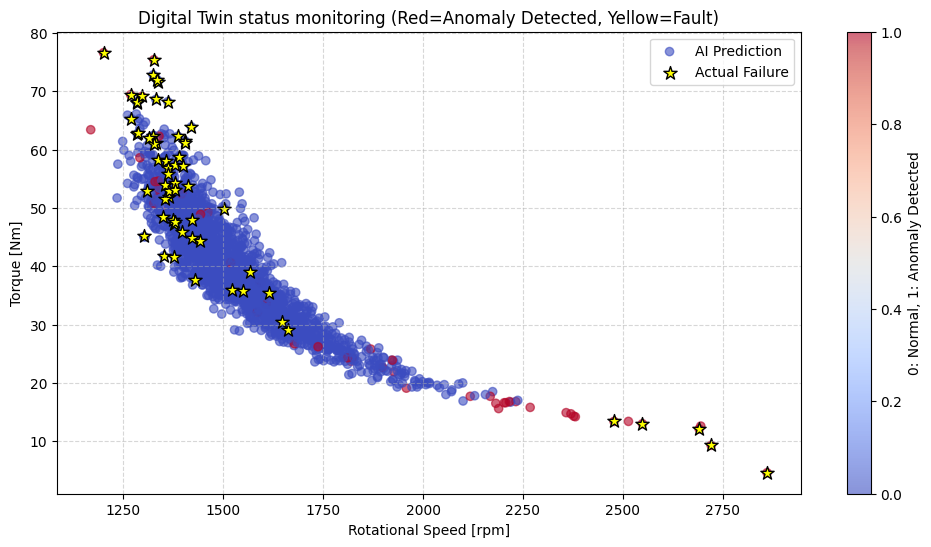

In [6]:
plt.figure(figsize=(12, 6))

# 1. 산점도 그리기 (AI의 예측 결과)
# 빨간색(1)은 이상치, 파란색(0)은 정상
scatter = plt.scatter(X_test['Rotational speed [rpm]'], X_test['Torque [Nm]'],
                     c=y_pred_iso, cmap='coolwarm', alpha=0.6, label='AI Prediction')

# 2. 실제 고장 데이터 표시 (검증용)
# 실제 고장난 데이터를 노란색 별표로 위에 덧그리기
actual_faults = X_test[y_test == 1]
plt.scatter(actual_faults['Rotational speed [rpm]'], actual_faults['Torque [Nm]'],
            color='yellow', s=100, marker='*', edgecolors='black', label='Actual Failure')

# 그래프 꾸미기
plt.title('Digital Twin status monitoring (Red=Anomaly Detected, Yellow=Fault)')
plt.xlabel('Rotational Speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.colorbar(scatter, label='0: Normal, 1: Anomaly Detected')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

## Gemini 챠트 분석결과

- 대시보드 시각화 차트는 제조 설비의 회전 속도(Rotational Speed)와 토크(Torque) 간의 관계를 보여주며, AI 기반의 이상 탐지 결과를 나타냅니다.

- 파란색 점: AI(Isolation Forest 모델)가 정상(Normal) 상태라고 판단한 데이터 포인트를 나타냅니다. 이들은 일반적인 운전 범주 내에 있는 것으로 보입니다.

- 빨간색 점: AI가 이상 징후(Anomaly)로 감지한 데이터 포인트를 나타냅니다. 이 점들은 정상 범주에서 벗어난 패턴을 보이므로, 잠재적인 고장이나 문제가 발생할 수 있음을 경고합니다.

- 노란색 별표: 실제 데이터에서 고장(Actual Failure)이 발생했던 지점을 나타냅니다. 이 노란색 별표들을 통해 AI가 탐지한 이상 징후(빨간색 점)가 실제 고장과 얼마나 잘 일치하는지 확인할 수 있습니다.

- 이 차트를 통해 디지털 트윈 시스템이 실시간으로 설비의 이상 징후를 감지하여 고장 발생 전에 예방적인 조치를 취할 수 있도록 돕는 원리를 시각적으로 이해할 수 있습니다.

#📘 [보너스 세션] 텍스트 데이터 비지도 학습: 제조 로그 토픽 모델링 (LDA)

주제: 작업자의 수리 일지(Log)에서 자동으로 주요 고장 원인(Topic) 추출하기

## 실습 개요
1. 제조 텍스트 데이터와 LDA 모델링

- 숫자로 된 센서 데이터 분석을 마쳤으니, 이번에는 텍스트 데이터를 분석해 보겠습니다.

- 제조 현장에는 매일 수많은 유지보수 로그(Maintenance Log)가 쌓이지만, 대부분 활용되지 못하고 버려집니다.

- 우리는 LDA(Latent Dirichlet Allocation) 알고리즘을 사용하여, 라벨(정답)이 없는 텍스트 데이터에서 '숨겨진 주제(Topic)'를 자동으로 찾아내는 비지도 학습을 수행할 것입니다.

- 시나리오: 공장 내 설비 보전 팀이 남긴 짧은 메모들을 분석하여, 현재 공장에서 가장 빈번하게 발생하는 3가지 문제 유형을 도출합니다.

In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 가상의 제조 현장 유지보수 로그 데이터 생성
# (실제 현장에서는 엑셀이나 DB에서 가져오게 됩니다)
logs = [
    "Motor overheating and shutdown",         # 모터 과열
    "Pump vibration level high",              # 펌프 진동
    "Software update failed error 404",       # SW 오류
    "Bearing noise detected in joint",        # 베어링 소음
    "Connection timeout with server",         # 서버 연결 끊김
    "Oil leak in hydraulic pump system",      # 유압 펌프 누유
    "PLC controller signal lost",             # PLC 신호 유실
    "Motor replacement required due to wear", # 모터 마모
    "System reboot needed for update",        # 시스템 재부팅
    "High temperature alarm in motor unit",   # 모터 고온 경보
    "Network cable disconnected",             # 네트워크 케이블 단선
    "Hydraulic pressure drop and leak",       # 유압 저하
    "Bearing seizure caused stoppage",        # 베어링 고착
    "API response timeout error",             # API 응답 시간초과
    "Vibration detected in main shaft"        # 메인 샤프트 진동
]

# 데이터프레임으로 변환
df_text = pd.DataFrame(logs, columns=['log_content'])

print("=== 유지보수 로그 샘플 (총 {}건) ===".format(len(df_text)))
display(df_text.head())

=== 유지보수 로그 샘플 (총 15건) ===


log_content
0    Motor overheating and shutdown
1         Pump vibration level high
2  Software update failed error 404
3   Bearing noise detected in joint
4    Connection timeout with server

## 텍스트 전처리 (Vectorization)
2. 컴퓨터가 이해하는 숫자로 변환

- 컴퓨터는 글자를 이해할 수 없으므로, 이를 숫자 행렬로 바꿔야 합니다.

- CountVectorizer를 사용하여 문장에 등장한 단어들의 빈도수를 셉니다. (Bag of Words 방식)

- stop_words='english': 'and', 'the', 'in' 같은 의미 없는 조사/관사를 자동으로 제거합니다.

In [8]:
# 1. 단어 빈도 벡터화 (Document-Term Matrix 생성)
# 영문 불용어(stop words) 제거 포함
vectorizer = CountVectorizer(stop_words='english', max_features=1000)

# 텍스트를 숫자 행렬로 변환
dtm = vectorizer.fit_transform(df_text['log_content'])

# 생성된 단어 사전 확인 (어떤 단어들이 잡혔는지)
print("=== 추출된 주요 단어 목록 ===")
print(vectorizer.get_feature_names_out())

print(f"\n변환된 행렬 크기: {dtm.shape}")
# (문서 수, 단어 수) 가 출력됨

=== 추출된 주요 단어 목록 ===
['404' 'alarm' 'api' 'bearing' 'cable' 'caused' 'connection' 'controller'
 'detected' 'disconnected' 'drop' 'error' 'failed' 'high' 'hydraulic'
 'joint' 'leak' 'level' 'lost' 'main' 'motor' 'needed' 'network' 'noise'
 'oil' 'overheating' 'plc' 'pressure' 'pump' 'reboot' 'replacement'
 'required' 'response' 'seizure' 'server' 'shaft' 'shutdown' 'signal'
 'software' 'stoppage' 'temperature' 'timeout' 'unit' 'update' 'vibration'
 'wear']

변환된 행렬 크기: (15, 46)


## LDA 모델 학습
3. LDA 모델링: 숨겨진 패턴 찾기

- 이제 LDA(Latent Dirichlet Allocation) 모델을 학습시킵니다. LDA는 "문서는 여러 주제(Topic)의 혼합이고, 주제는 여러 단어의 혼합이다"라는 가정하에 확률적으로 주제를 추론합니다.

- 우리는 이 로그들이 크게 3가지 유형(Topic)으로 나뉠 것이라고 가정하고(n_components=3), 모델에게 분류를 시켜보겠습니다.

In [9]:
# LDA 모델 생성 (3개의 토픽을 찾도록 설정)
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)

# 학습 수행
lda_model.fit(dtm)

print("LDA 모델 학습 완료!")

LDA 모델 학습 완료!


## 결과 해석
4. 결과 해석: 과연 어떤 이슈들이 있었을까?

- 학습된 모델이 찾아낸 3가지 토픽이 무엇인지 확인해 봅니다. 각 토픽별로 비중이 높은 핵심 키워드(Top words)를 출력하여, 사람이 그 의미를 해석합니다.

- 예상: 기계적 결함(Mechanical), 소프트웨어/네트워크(IT), 유압/펌프(Hydraulic) 등으로 나뉠 수 있습니다.

In [12]:
# 토픽별 주요 키워드 출력 함수
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n[Topic {topic_idx + 1}]")
        # 각 토픽에서 가장 비중이 높은 단어들을 역순으로 정렬
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# 각 토픽별 상위 4개 단어 출력
no_top_words = 4
display_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words)


[Topic 1]
motor timeout high error

[Topic 2]
hydraulic leak pump vibration

[Topic 3]
bearing signal lost controller


## 실제 로그 분류
5. 기존 로그 데이터의 토픽 분류 결과

- 마지막으로, 우리가 입력했던 로그들이 각각 어떤 토픽으로 분류되었는지 확률적으로 확인해 봅니다.

- 이것이 바로 디지털 트윈 상에서 "현재 공장에는 2번 유형(IT 장애)의 이슈가 급증하고 있습니다"라고 리포팅해 줄 수 있는 기초가 됩니다.

In [13]:
# 각 문서(로그)가 어떤 토픽에 해당할 확률이 높은지 예측
topic_values = lda_model.transform(dtm)

# 가장 높은 확률을 가진 토픽 번호를 추출
df_text['Topic'] = topic_values.argmax(axis=1) + 1

# 결과 출력 (로그 내용과 할당된 토픽 번호)
print("=== 로그별 자동 토픽 분류 결과 ===")
display(df_text.head(10))

# (옵션) 토픽별 이름 매핑 (사람이 해석 후 붙임)
# 예: Topic 1 -> 기계/베어링, Topic 2 -> SW/네트워크, Topic 3 -> 펌프/유압
# (실행 결과에 따라 매핑은 달라질 수 있습니다)

=== 로그별 자동 토픽 분류 결과 ===


log_content  Topic
0          Motor overheating and shutdown      1
1               Pump vibration level high      2
2        Software update failed error 404      2
3         Bearing noise detected in joint      2
4          Connection timeout with server      1
5       Oil leak in hydraulic pump system      2
6              PLC controller signal lost      3
7  Motor replacement required due to wear      1
8         System reboot needed for update      1
9    High temperature alarm in motor unit      1

## LLM과의 연결 고리

- LDA는 단어 개수만 세기 때문에 '맥락'을 모릅니다.

- 하지만 내일 배울 LLM은 맥락을 이해합니다.

- 내일은 이 로그를 LLM에게 던져주고 해결책까지 물어볼 겁니다